## **Convolutional Neural Network (CNN)**

##Loading Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip

--2021-07-10 05:44:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   112MB/s    in 0.6s    

2021-07-10 05:44:45 (112 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
train_dir = '/content/cats_and_dogs_filtered/train'
validation_dir = '/content/cats_and_dogs_filtered/validation'

BATCH_SIZE = 32                    
IMG_SIZE = (160, 160)   # object tf.data     a = (1,2)   a[0] = 1   a[1] = 2
 
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

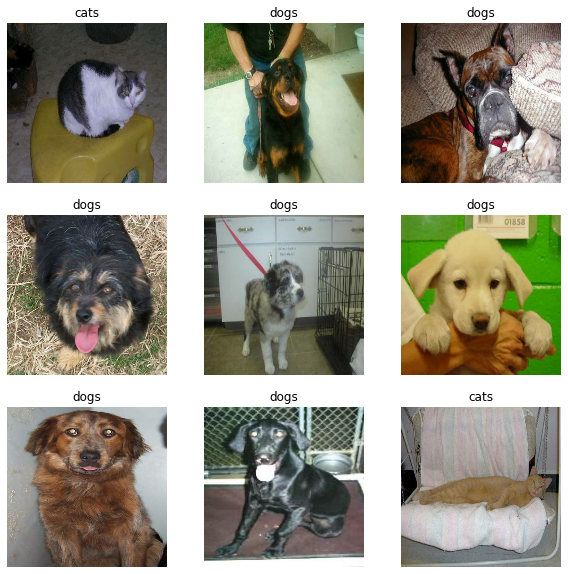

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)       # 1000
test_dataset = validation_dataset.take(val_batches // 5)         #   200
validation_dataset = validation_dataset.skip(val_batches // 5)    # 800   #interpolates     1 2 3 4    ->  1 3 

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Rescale pixel values
The model we create would expect pixel values in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use Rescalling layer

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)     # 160 , 160 , 3   # (160 , 160)   + (3,)    = (160, 160, 3)
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1,input_shape = IMG_SHAPE)  # 0 -255   # 0 2   # -1 1 


# Defining a Shallow CNN Model

Here we define a small CNN network. It contains a convolutional layer having 32 filters each of size (3 × 3).
Then we flatten the feature map using global averaging and add 2 dense layers. First one having 100 neurons and last one having
10 neurons i.e. equal to number of classes.

In [ ]:
model = tf.keras.Sequential()
model.add(rescale)   # 160 , 160 , 3
model.add(tf.keras.layers.Conv2D(32, (3,3), strides = (1,1), padding = 'same' , activation='relu'))    # 160 160 32   # 160 160 64  64
model.add(tf.keras.layers.GlobalAveragePooling2D())   # 32       #160 x 160  -> 1, 1 ,1 ,....,1    -> 32   # 200 145 128    128
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # probability for first class   P1   P2= 1-P1

In [ ]:
#    multi classs   == >2       10 class  Dense(10)   softmax categorical_crossentropy     -> categorical_crossentropy (True)
#    binary classs   == 2     2 neurons    ---> softmax categorical_crossentropy   -> categorical_crossentropy(True)
#                          1 neuron    -->    sigmoid  binary_crossentropy    -> binary(True)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 160, 160, 32)      896       
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 4,297
Trainable params: 4,297
Non-trainable params: 0
_________________________________________________________________



# Compiling the model

Once the model is defined, we have to compile it. While compiling we provide the loss function to be used, the optimizer and any metric. Here we will use crossentropy loss with Adam optimizer and accuracy as a metric.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training/Fitting the model

Now the model is ready to be trained. We will provide training data to the network. Also we will specify the validation data, over which the model will only be validated.

Epoch 1/2
63/63 [==============================] - 26s 413ms/step - loss: 0.6909 - accuracy: 0.5000 - val_loss: 0.6896 - val_accuracy: 0.4889
Epoch 2/2
63/63 [==============================] - 26s 411ms/step - loss: 0.6901 - accuracy: 0.5000 - val_loss: 0.6886 - val_accuracy: 0.4988


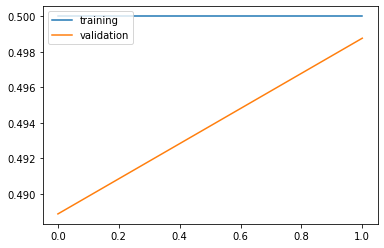

In [ ]:
# Training model

history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=validation_dataset)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()


# Evaluating the model

Finally we will evaluate the model on the testing dataset.

In [ ]:
# Final evaluation of the model

scores = model.evaluate(test_dataset)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))

6/6 [==============================] - 1s 171ms/step - loss: 0.6884 - accuracy: 0.4948
Baseline Error: 50.52%



# Defining a Deep Model

Now we will define a multi layer neural network in which we will add $2$ hidden layers having $500$ and $100$ neurons.

In [ ]:
model = tf.keras.Sequential()
model.add(rescale)
model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding = 'same', activation = 'relu'))    #   161 161 32
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding = 'valid'))     #    80 80 32    
model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())    ->64
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

# Analyzing Model Summary

The following function provides us with detailed summary of the model. We can use it after we have defined
our model.

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 160, 160, 32)      896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 160, 160, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 80, 80, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 80, 80, 64)        36928     
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)               

Epoch 1/2
63/63 [==============================] - 246s 4s/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.4851
Epoch 2/2
63/63 [==============================] - 245s 4s/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6897 - val_accuracy: 0.5012


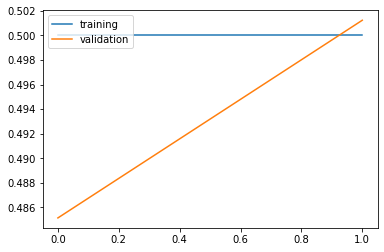

6/6 [==============================] - 6s 883ms/step - loss: 0.6897 - accuracy: 0.5260
Baseline Error: 47.40%


In [ ]:
import h5py

# Compile model

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training model

history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=validation_dataset)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

# Final evaluation of the model

# Final evaluation of the model

scores = model.evaluate(test_dataset)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
model = tf.keras.Sequential()
model.add(rescale)
model.add(base_model)
model.add(global_average_layer)
model.add(tf.keras.layers.Dropout(0.2))
model.add(prediction_layer)

Epoch 1/2
63/63 [==============================] - 44s 655ms/step - loss: 0.6885 - accuracy: 0.5830 - val_loss: 0.4911 - val_accuracy: 0.7265
Epoch 2/2
63/63 [==============================] - 41s 648ms/step - loss: 0.4597 - accuracy: 0.7355 - val_loss: 0.3400 - val_accuracy: 0.8366


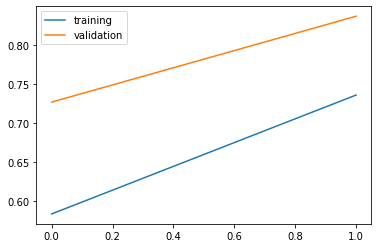

6/6 [==============================] - 3s 463ms/step - loss: 0.3445 - accuracy: 0.8125
Baseline Error: 18.75%


In [ ]:
# Compile model

base_learning_rate = 1e-7
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training model

history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=validation_dataset)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

# Final evaluation of the model

# Final evaluation of the model

scores = model.evaluate(test_dataset)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))